<a href="https://colab.research.google.com/github/renanalencar/projeto-cnn-squeezenet/blob/main/Projeto_VGG_vFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projeto de Redes Neurais 

## Referências: 



1. [Estudo sobre Câncer de Cólon utilizando a mesma base com modelod e CNN](https://www.kaggle.com/aayushrajput/lung-colon-cancer)
2. [Modelo de SqueezeNet para reconhecimento de comida](https://www.kaggle.com/kmader/food-squeezenet) 
3. [SqueezeNet no Keras](https://codelabs.developers.google.com/codelabs/keras-flowers-squeezenet#6)
4. [Entendendo Redes Convolucionais (CNNs) ](https://medium.com/neuronio-br/entendendo-redes-convolucionais-cnns-d10359f21184#:~:text=H%C3%A1%20muitas%20fun%C3%A7%C3%B5es%2C%20como%20sigmoid,quando%20comparada%20a%20outras%20fun%C3%A7%C3%B5es)
5. [Uma introdução as redes neurais convolucionais utilizando o Keras](https://medium.com/data-hackers/uma-introdu%C3%A7%C3%A3o-as-redes-neurais-convolucionais-utilizando-o-keras-41ee8dcc033e)
6. [Tutorial prático do Keras](https://cv-tricks.com/tensorflow-tutorial/keras/)
7. [Métricas de avaliação de modelo](https://gabrielschade.github.io/2019/03/12/ml-classificacao-metricas.html)


## Erro na biblioteca keras_applications e pycm

In [ ]:
!pip install keras_applications

     |████████████████████████████████| 51kB 3.5MB/s 


In [ ]:
!pip install pycm

     |████████████████████████████████| 71kB 4.9MB/s 
     |████████████████████████████████| 573kB 16.6MB/s 


## Kaggle

In [ ]:
! pip install -q kaggle
from google.colab import files
# Choose the kaggle.json file that you downloaded 
files.upload()
! mkdir ~/.kaggle
# Make directory named kaggle and copy kaggle.json file there.
! cp kaggle.json ~/.kaggle/
# Change the permissions of the file.
! chmod 600 ~/.kaggle/kaggle.json
# That's all! You can check if everything's okay by running this command.
! kaggle datasets list
# Download Data
! kaggle datasets download -d andrewmvd/lung-and-colon-cancer-histopathological-images
# Use unzip command to unzip the data:
# For example, Create a directory named train, ! mkdir train unzip train data there.
! mkdir input
# unzip train data there,
! unzip lung-and-colon-cancer-histopathological-images.zip -d input

A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: input/lung_colon_image_set/lung_image_sets/lung_scc/lungscc1.jpeg  
  inflating: input/lung_colon_image_set/lung_image_sets/lung_scc/lungscc10.jpeg  
  inflating: input/lung_colon_image_set/lung_image_sets/lung_scc/lungscc100.jpeg  
  inflating: input/lung_colon_image_set/lung_image_sets/lung_scc/lungscc1000.jpeg  
  inflating: input/lung_colon_image_set/lung_image_sets/lung_scc/lungscc1001.jpeg  
  inflating: input/lung_colon_image_set/lung_image_sets/lung_scc/lungscc1002.jpeg  
  inflating: input/lung_colon_image_set/lung_image_sets/lung_scc/lungscc1003.jpeg  
  inflating: input/lung_colon_image_set/lung_image_sets/lung_scc/lungscc1004.jpeg  
  inflating: input/lung_colon_image_set/lung_image_sets/lung_scc/lungscc1005.jpeg  
  inflating: input/lung_colon_image_set/lung_image_sets/lung_scc/lungscc1006.jpeg  
  inflating: input/lung_colon_image_set/lung_image_sets/lung_scc/lungscc1007.jpeg  
  inflating: input/lung

## Importanto as bibliotecas necessárias

In [ ]:
import h5py
import numpy as np

import tensorflow as tf

from tensorflow.keras import datasets, layers, models

from keras import backend as K
from keras_applications.imagenet_utils import _obtain_input_shape
from keras.applications.vgg16 import VGG16
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.engine.topology import get_source_inputs
from keras.models import Model, model_from_json
from keras.layers import Dense,Flatten
from keras.layers import Input, Activation, concatenate
from keras.layers import Flatten, Dropout
from keras.layers import Dense,Flatten
from keras.layers import Convolution2D, MaxPooling2D,Conv2D
from keras.layers import AveragePooling2D, BatchNormalization
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.optimizers import SGD, RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import get_file
from keras.utils import layer_utils
from sklearn.metrics import f1_score,recall_score, precision_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('error')
from pycm import *
   
# from visual_callbacks import AccLossPlotter

from google.colab import drive
drive.mount('/content/drive', force_remount=True)
%matplotlib inline

Mounted at /content/drive


## Pré-processamento

O conjunto de dados contém 15.000 imagens coloridas em 3 classes, com 5.000 imagens em cada classe. O conjunto de dados é dividido em 12.000 imagens de treinamento e 3.000 imagens de teste. 

### Variáveis 

In [ ]:
base_dir = '/content/drive/Shareddrives/REDES_NEURAIS_ENG74317/projeto_cnn_squeezenet/' # Diretório dos arquivos 
# data_dir = '/content/input/lung_colon_image_set/lung_image_sets/' # Diretório das imagems 
data_dir = '/content/drive/Shareddrives/REDES_NEURAIS_ENG74317/projeto_cnn_squeezenet/input/lung_image_sets/' # Diretório das imagems 
width, height, nb_class = 768, 768, 3 # Dimensões da entrada
batch_size = 4 # Tamanho do lote para treinamento
shuffle = True # Sortear as amostras 
seed = 42 # Número de sementes 
nb_epoch = 15 # Número de épocas 
loss='categorical_crossentropy' # Algoritmo de optmização das Redes Convolucionais
optimizer_cnn='adam' # Algoritmo de optmização das Redes Convolucionais
optimizer_sn = 'sgd' # Algoritmo de optmização da SqueezeNet
metrics='accuracy' # Métrica utilizada 
target_size = (width, height)
input_shape =  (width, height, nb_class)

### Pré-processamento das imagens 

In [ ]:
def PreProcess(data_dir,target_size,batch_size,shuffle,seed):
    
    datagen_cnn = tf.keras.preprocessing.image.ImageDataGenerator(validation_split = 0.2)

    train_cnn = datagen_cnn.flow_from_directory(data_dir,
                                          class_mode = "categorical",
                                          target_size = target_size,
                                          color_mode="rgb",
                                          batch_size = batch_size, 
                                          shuffle = shuffle,
                                          subset='training',
                                          seed = seed)

    validation_cnn = datagen_cnn.flow_from_directory(data_dir,
                                          class_mode = "categorical",
                                          target_size = target_size,
                                          color_mode="rgb",
                                          batch_size = batch_size, 
                                          shuffle = shuffle,
                                          subset='validation',
                                          seed = seed)

    return train_cnn, validation_cnn 

# VGG

### Modelo VGG

In [ ]:
def Model_VGG():
  model = VGG16(include_top=False, input_shape=(768, 768, 3))

  for layer in model.layers:
   layer.trainable = False
  
  flat1 = Flatten()(model.layers[-1].output)
  class1 = Dense(1024, activation='relu')(flat1)
  class2 = Dense(512, activation='relu')(class1)
  class3 = Dense(256, activation='relu')(class2)
  class4 = Dense(128, activation='relu')(class3)
  output = Dense(3, activation='softmax')(class4)

  model = Model(inputs=model.inputs, outputs=output)

  return model

### Função para compilar o modelo da VGG

In [ ]:
def Compile_Model_VGG(loss, optimizer_cnn, metrics):
  
  model_vgg = Model_VGG()
  opt = RMSprop(lr=0.001, decay=0.01, momentum=0.9)
  model_vgg.compile(loss=loss, optimizer=opt, metrics=[metrics])
  model_vgg.summary()

  return model_vgg

### Função de treinamento da VGG

In [ ]:
def Train_Model_VGG(model_vgg, train_cnn, nb_epoch, validation_cnn):
     
     history_vgg = model_vgg.fit(train_cnn, epochs = nb_epoch,  validation_data=validation_cnn)

     # salvar modelo para posterior avaliação      
     model_json = model_vgg.to_json()
     model_name = "Modelo_VGG"
     with open(base_dir+'models/'+model_name+".json", "w") as json_file:
      json_file.write(model_json)
     model_vgg.save_weights(base_dir+'weights/'+model_name+'.h5')

     return history_vgg

### Função para execução da VGG

In [ ]:
def Execute_Model_VGG():
  
    train_cnn, validation_cnn = PreProcess(data_dir,target_size,batch_size,shuffle,seed)
    model_vgg = Compile_Model_VGG(loss, optimizer_cnn, metrics)
    history_vgg = Train_Model_VGG(model_vgg, train_cnn, nb_epoch, validation_cnn)

    # Plotar a curva de aprendizagem
    history_dict = history_vgg.history
    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    accuracy = history_dict['accuracy']
    val_accuracy = history_dict['val_accuracy']
    
    epochs = range(1, len(loss_values) + 1)
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))

    # Plotar a Perdas vs Épocas
    ax.plot(epochs, loss_values, 'bo', label='Perda de treinamento')
    ax.plot(epochs, val_loss_values, 'b', label='Perda de validação')
    ax.set_title('Perdas de Treinamento & Validação', fontsize=16)
    ax.set_xlabel('Épocas', fontsize=16)
    ax.set_ylabel('Perdas', fontsize=16)
    ax.legend()

    ax.figure.savefig(base_dir+'graphs/Curva_de_aprendizagem_VGG.png')
  

### Função para avaliação  da VGG

In [ ]:
def Evaluate_Model_VGG():
    datagen_cnn = tf.keras.preprocessing.image.ImageDataGenerator(validation_split=0.2,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

    test_cnn = datagen_cnn.flow_from_directory(data_dir,
                                          class_mode = "categorical",
                                          target_size = target_size,
                                          color_mode="rgb",
                                          batch_size = batch_size, 
                                          shuffle = shuffle,
                                          subset='validation',
                                          seed = seed)
    
    # train_cnn, validation_cnn = PreProcess(data_dir,target_size,batch_size,shuffle,seed)



    # train_cnn, validation_cnn = PreProcess(data_dir,target_size,batch_size,shuffle,seed)
    
    # Recuperando o modelo Treinado da CNN

    
    with open(base_dir+'models/Modelo_VGG.json','r') as modelo:
      json = modelo.read()
    model_vgg = model_from_json(json)

    # Recuperando os pesos do treinamento da CNN
    model_vgg.load_weights(base_dir+'weights/Modelo_VGG.h5') 

    Y_pred = model_vgg.predict(test_cnn)
    y_pred = np.argmax(Y_pred, axis=1)
    
    cm = ConfusionMatrix(actual_vector=test_cnn.classes, predict_vector=y_pred)
    
    print('                 Aca\tN\tSCC')
    print('A sensibilidade :{}\t{}\t{}'.format(cm.TPR[0],cm.TPR[1],cm.TPR[2]))    
    print('A especificidade:{}\t{}\t{}'.format(cm.TNR[0],cm.TNR[1],cm.TNR[2]))

    # guardar o resultado das métricas
    model_name = "Modelo_VGG"
    with open(base_dir+'results/'+model_name+'.txt', 'w') as arquivo:
      print('                 Aca\tN\tSCC', file=arquivo)
      print('A sensibilidade :{}\t{}\t{}'.format(cm.TPR[0],cm.TPR[1],cm.TPR[2]), file=arquivo)    
      print('A especificidade:{}\t{}\t{}'.format(cm.TNR[0],cm.TNR[1],cm.TNR[2]), file=arquivo)

    cm.plot(cmap=plt.cm.Greens,number_label=True,plot_lib="matplotlib")

    fpr = {}
    tpr = {}
    thresh ={}

    n_class = 3

    for i in range(n_class):    
        fpr[i], tpr[i], thresh[i] = roc_curve(test_cnn.classes, Y_pred[:,i], pos_label=i)

    plt.figure()
    plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
    plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
    plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
    plt.title('Multiclass ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive rate')
    plt.legend(loc='best')
    plt.show()
    plt.savefig(base_dir+'graphs/Multiclass_ROC_VGG.png',dpi=300); 

### Chamada para execução da VGG

Found 12000 images belonging to 3 classes.
Found 3000 images belonging to 3 classes.
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 768, 768, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 768, 768, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 768, 768, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 384, 384, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 384, 384, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 384, 384, 128)     147584    
________________________________________

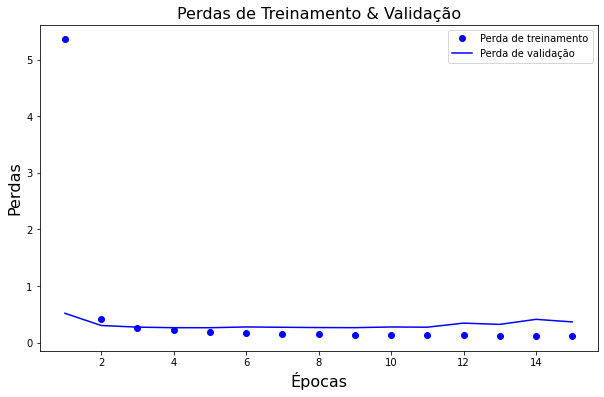

In [ ]:
Execute_Model_VGG()

### Chamada para avaliação da VGG

Found 3000 images belonging to 3 classes.
                 Aca	N	SCC
A sensibilidade :0.103	0.65	0.291
A especificidade:0.902	0.378	0.742


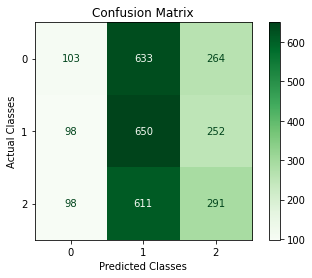

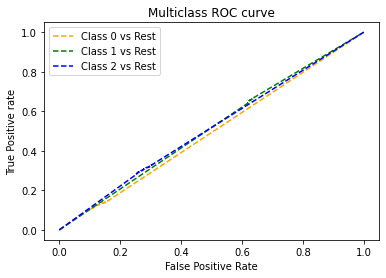

<Figure size 432x288 with 0 Axes>

In [ ]:
Evaluate_Model_VGG()